#Projet "imbalanced data"

Option 1: tester deux codes parmi ceux présentés sur le site https://github.com/ZhiningLiu1998/awesome-imbalanced-learning, avec des données différentes de celles utilisées dans le code. Ecrire un rapport sur vos constatations, les performances observées, les moyens pour les améliorer (en jouant sur tel ou tel paramètre par exemple).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier

J'ai choisi les données "credit card fraud detection", présentes sur kaggle, car elles présentent un profil idéal pour ce projet : les fraudes sont très minoritaires, puisqu'il y a seulement 492 fraudes sur 284 807 transactions. L'ensemble de données est donc très fortement déséquilibré, la classe positive (fraudes) représentant 0,172 % de toutes les transactions. L'honnêteté des gens est donc la classe majoritaire, c'est rassurant - mais nous voulons néanmoins détecter nos fraudeurs. Or, un modèle d'apprentissage automatique mis en place sur un ensemble si déséquilibré a peu de chances de nous y aider efficacement...

Nous allons donc lui fournir des données rééchantillonnées.

Pour cela, j'ai choisi de tester une méthode d'over-sampling : ADASYN, qui ressemble à SMOTE mais avec quelques nuances. Et une méthode d'under-sampling : NCR, qui, traduit en français, signifie "règle de nettoyage par voisinage".

J'utilise un SVM, dont notre enseignant nous a expliqué en cours les raisons pour lesquelles il fait partie des modélisations les plus adaptées en cas de données déséquilibrées. En effet, contrairement par exemple à une régression logistique qui prendra en compte tous les points de manière identique, le SVM ne repose que sur les points qui sont "vecteurs de support" dans chaque classe - ce qui, mécaniquement, réduit le déséquilibre, puisque dans chacune des classes, seuls les points les plus proches de la frontière interclasse servent au modèle.

#Chargement de la table et étude de ses caractéristiques importantes

In [ ]:


# Charger le fichier CSV
df = pd.read_csv('/content/drive/MyDrive/donnees/creditcard.csv')

# Afficher les premières lignes du DataFrame
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

La table comprend la variable Class (fraude/non-fraude), la variable amount (montant de la transaction), et la variable Time (qui mesure les secondes écoulées entre chaque transaction et la première transaction de la table). Puis 27 autres variables, de V1 à V28, qui sont le résultat d'une transformation PCA - on ne sait pas à quoi elles correspondent, et c'est voulu, du fait du caractère sensible des données bancaires et des obligations de confidentialité qui en découlent.

In [ ]:
# Obtenir les effectifs par modalités de la variable 'Class'
effectifs = df['Class'].value_counts()

# Afficher les résultats
print(effectifs)

Class
0    284315
1       492
Name: count, dtype: int64


In [ ]:
# Statistiques univariées pour la variable 'Amount'
statistiques = df['Amount'].describe()

# Afficher les statistiques
print(f"statistiques pour l'ensemble des transactions :{statistiques}")


# Filtrer les transactions frauduleuses (Class == 1)
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

# Statistiques univariées pour la variable 'Amount' des transactions frauduleuses et non frauduleuses
statistiques_non_fraud = non_fraud['Amount'].describe()
statistiques_fraud = fraud['Amount'].describe()

# Afficher les statistiques
print("\nStatistiques des montants pour les transactions frauduleuses :")
print(statistiques_fraud)

statistiques pour l'ensemble des transactions :count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

Statistiques des montants pour les transactions frauduleuses :
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


<ipython-input-38-096c6f643b00>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class_label', y='Amount', data=df, palette="Set2")


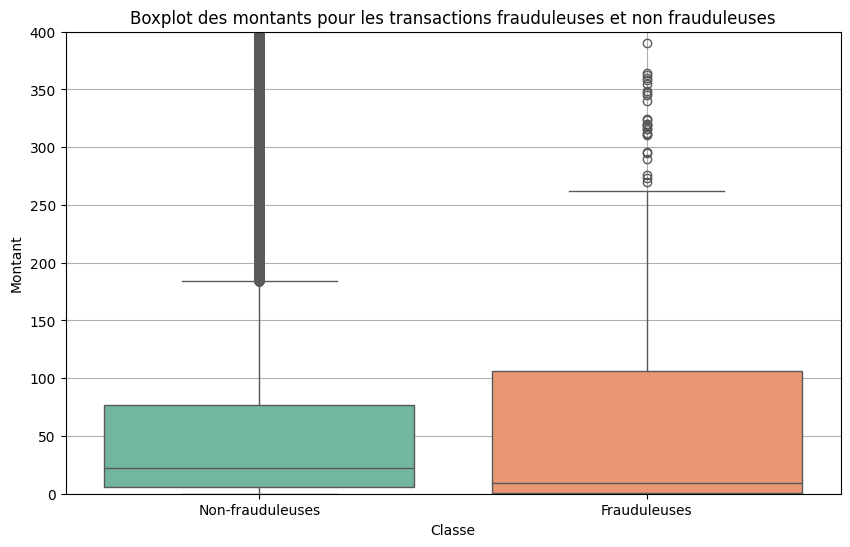

In [ ]:

# Filtrer les transactions frauduleuses (Class == 1)
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

# Créer une nouvelle colonne pour l'étiquetage des classes
df['Class_label'] = df['Class'].apply(lambda x: 'Frauduleuses' if x == 1 else 'Non-frauduleuses')

# Configurer la taille du graphique
plt.figure(figsize=(10, 6))

# Créer un boxplot
sns.boxplot(x='Class_label', y='Amount', data=df, palette="Set2")

# Ajouter des titres et des labels
plt.title('Boxplot des montants pour les transactions frauduleuses et non frauduleuses')
plt.xlabel('Classe')
plt.ylabel('Montant')

# Limiter l'axe des abscisses à 5000
plt.xlim(-0.5, 1.5)  # Limiter à la taille des catégories de classe
plt.ylim(0, 400)    # Limiter l'axe des ordonnées (montants) à 5000

# Afficher le graphique
plt.grid(True)
plt.show()

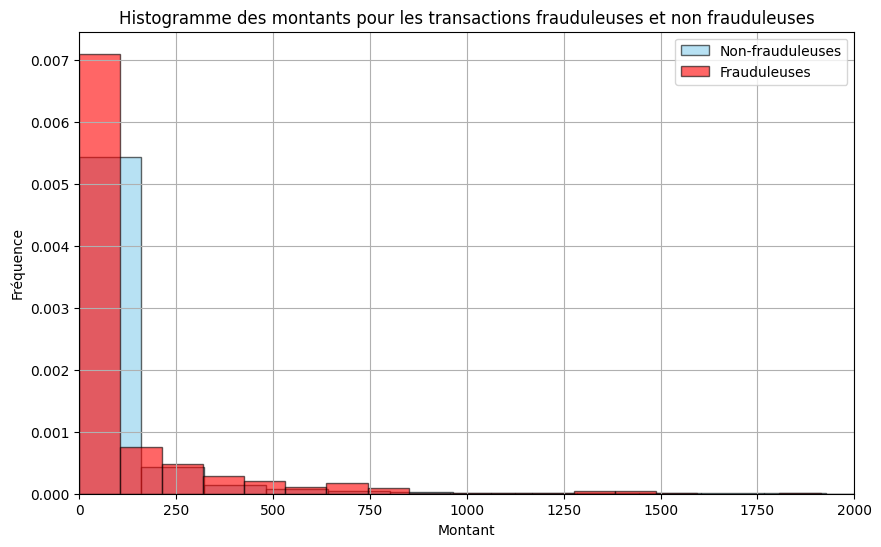

In [ ]:
# Filtrer les transactions frauduleuses (Class == 1)
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

# Histogramme pour les transactions non frauduleuses (Class == 0)
plt.figure(figsize=(10, 6))
plt.hist(non_fraud['Amount'], bins=160, alpha=0.6, label='Non-frauduleuses', color='skyblue', edgecolor='black', density=True)

# Histogramme pour les transactions frauduleuses (Class == 1)
plt.hist(fraud['Amount'], bins=20, alpha=0.6, label='Frauduleuses', color='red', edgecolor='black', density=True)

# Ajouter des labels et un titre
plt.title('Histogramme des montants pour les transactions frauduleuses et non frauduleuses')
plt.xlabel('Montant')
plt.ylabel('Fréquence')

# Ajouter une légende pour identifier les histogrammes
plt.legend()

# Limiter l'axe des abscisses à 2000
plt.xlim(0, 2000)

# Afficher le graphique
plt.grid(True)
plt.show()


###préparation des données pour le SVM (et séparation en données d'entrainement et de test, avant le rééchantillonnage qui, lui, ne porte que sur les données d'entrainement).

In [ ]:
# Sélectionner les variables explicatives (features) et la variable cible (target)
X = df.drop(columns=['Class','Class_label'])  # Variables explicatives (toutes les colonnes sauf 'Class')
y = df['Class']  # Variable cible (Class)

In [ ]:
# Normaliser les données (SVM est sensible à la mise à l'échelle des données)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)# Appliquer le scaling sur les données

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [ ]:
# Obtenir les effectifs par modalités de la variable 'Class' dans l'ensemble d'entrainement

effectifs = y_train.value_counts()
# Afficher les résultats
print(effectifs)

Class
0    199008
1       356
Name: count, dtype: int64


##Expérimentation avec ADASYN

ADASYN ressemble à SMOTE, avec une nuance.

Contrairement à SMOTE, qui génère un nombre fixe de nouveaux échantillons synthétiques pour chaque point minoritaire, ADASYN génère un nombre variable d'échantillons en fonction de la densité locale des points de données. Cela permet de générer plus d'échantillons là où les points minoritaires sont rares ou difficiles à classifier.



In [ ]:
"""Class to perform over-sampling using ADASYN."""

# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
#          Christos Aridas
# License: MIT

import numbers

import numpy as np
from scipy import sparse #sous-module sparse qui permet de travailler avec des matrices creuses
                         #(matrices contenant principalement des zéros, utilisées pour économiser de la mémoire)
from sklearn.utils import _safe_indexing, check_random_state #_safe_indexing : permet d'indexer des tableaux de manière sécurisée
                                                             #check_random_state : garantit que le générateur de nombres aléatoires est valide et reproductible
from sklearn.utils._param_validation import HasMethods, Interval #HasMethods : permet de vérifier si un objet possède des méthodes spécifiques
                                                                 #Interval : est utilisé pour vérifier si un paramètre numérique est dans une plage valide.

from ..utils import Substitution, check_neighbors_object
from ..utils._docstring import _random_state_docstring
from .base import BaseOverSampler #classe de base pour d'autres algorithmes de sur-échantillonnage, et à partir de laquelle ADASYN hérite ?

#décorateur dont je ne comprends pas encore bien ce qu'il fait (apparemment, il ajoute de la documentation à la classe ?):
@Substitution(
    sampling_strategy=BaseOverSampler._sampling_strategy_docstring,
    random_state=_random_state_docstring,
)
class ADASYN(BaseOverSampler): #déclare la classe ADASYN, qui hérite de BaseOverSampler
    """Oversample using Adaptive Synthetic (ADASYN) algorithm.

    This method is similar to SMOTE but it generates different number of
    samples depending on an estimate of the local distribution of the class
    to be oversampled.

    Read more in the :ref:`User Guide <smote_adasyn>`.

    Parameters
    ----------
    {sampling_strategy}

    {random_state}

    n_neighbors : int or estimator object, default=5
        The nearest neighbors used to define the neighborhood of samples to use
        to generate the synthetic samples. You can pass:

        - an `int` corresponding to the number of neighbors to use. A
          `~sklearn.neighbors.NearestNeighbors` instance will be fitted in this
          case.
        - an instance of a compatible nearest neighbors algorithm that should
          implement both methods `kneighbors` and `kneighbors_graph`. For
          instance, it could correspond to a
          :class:`~sklearn.neighbors.NearestNeighbors` but could be extended to
          any compatible class.

    Attributes
    ----------
    sampling_strategy_ : dict
        Dictionary containing the information to sample the dataset. The keys
        corresponds to the class labels from which to sample and the values
        are the number of samples to sample.

    nn_ : estimator object
        Validated K-nearest Neighbours estimator linked to the parameter `n_neighbors`.

    n_features_in_ : int
        Number of features in the input dataset.

        .. versionadded:: 0.9

    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during `fit`. Defined only when `X` has feature
        names that are all strings.

        .. versionadded:: 0.10

    See Also
    --------
    SMOTE : Over-sample using SMOTE.

    SMOTENC : Over-sample using SMOTE for continuous and categorical features.

    SMOTEN : Over-sample using the SMOTE variant specifically for categorical
        features only.

    SVMSMOTE : Over-sample using SVM-SMOTE variant.

    BorderlineSMOTE : Over-sample using Borderline-SMOTE variant.

    Notes
    -----
    The implementation is based on [1]_.

    Supports multi-class resampling. A one-vs.-rest scheme is used.

    References
    ----------
    .. [1] He, Haibo, Yang Bai, Edwardo A. Garcia, and Shutao Li. "ADASYN:
       Adaptive synthetic sampling approach for imbalanced learning," In IEEE
       International Joint Conference on Neural Networks (IEEE World Congress
       on Computational Intelligence), pp. 1322-1328, 2008.

    Examples
    --------
    >>> from collections import Counter
    >>> from sklearn.datasets import make_classification
    >>> from imblearn.over_sampling import ADASYN
    >>> X, y = make_classification(n_classes=2, class_sep=2,
    ... weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
    ... n_features=20, n_clusters_per_class=1, n_samples=1000,
    ... random_state=10)
    >>> print('Original dataset shape %s' % Counter(y))
    Original dataset shape Counter({{1: 900, 0: 100}})
    >>> ada = ADASYN(random_state=42)
    >>> X_res, y_res = ada.fit_resample(X, y)
    >>> print('Resampled dataset shape %s' % Counter(y_res))
    Resampled dataset shape Counter({{0: 904, 1: 900}})
    """

    _parameter_constraints: dict = {
        **BaseOverSampler._parameter_constraints,
        "n_neighbors": [
            Interval(numbers.Integral, 1, None, closed="left"),
            HasMethods(["kneighbors", "kneighbors_graph"]),
        ],
    }#_parameter_constraints : Définit un dictionnaire de contraintes sur les paramètres de la classe, en étendant les contraintes définies dans BaseOverSampler.
    #Ici, il impose que n_neighbors soit un entier supérieur ou égal à 1 et que l'objet utilisé pour n_neighbors possède les méthodes kneighbors et kneighbors_graph

    def __init__( #initialise les paramètres de l'algorithme
        self,
        *,
        sampling_strategy="auto", #stratégie de sur-échantillonnage
        random_state=None,#graine pour la reproductibilité des résultats
        n_neighbors=5,#nombre de voisins à utiliser, avec une valeur par défaut de 5
    ):
        super().__init__(sampling_strategy=sampling_strategy)#Appelle le constructeur de la classe parente BaseOverSampler pour initialiser sampling_strategy
        self.random_state = random_state
        self.n_neighbors = n_neighbors

    def _validate_estimator(self):#méthode utilisée pour valider et créer les objets nécessaires à l'algorithme ADASYN. Elle vérifie que l'objet pour n_neighbors
                                  #est valide (par exemple, qu'il s'agit d'un modèle de voisins proches tel NearestNeighbors),
                                  #et crée cet objet avec la méthode check_neighbors_object.
        """Create the necessary objects for ADASYN"""
        self.nn_ = check_neighbors_object(#plus précisément : on vérifie et initialise l'objet nn_ qui représente les voisins dans le cadre de l'algorithme
            "n_neighbors", self.n_neighbors, additional_neighbor=1
        )#cela permet à ADASYN de générer des exemples synthétiques en utilisant les voisins les plus proches des instances minoritaires,
         #ce qui est l'une des étapes clés de l'algorithme.

    def _fit_resample(self, X, y): #méthode qui réalise le sur-échantillonnage de l'ensemble de données X et y (caractéristiques et étiquettes)
        self._validate_estimator()
        random_state = check_random_state(self.random_state)#ce, en validant d'abord l'estimateur via _validate_estimator(),
                                                            #puis en créant un générateur de nombres aléatoires avec check_random_state(self.random_state)

        X_resampled = [X.copy()]
        y_resampled = [y.copy()]#Créent des copies des données d'entrée X et des étiquettes y. Ces listes contiendront les données après resampling

        for class_sample, n_samples in self.sampling_strategy_.items():#Boucle qui parcourt chaque classe à échantillonner, puis pour chaque classe, vérifie
                                                                       #combien d'exemples synthétiques doivent être générés.
                                                                       #Si le nombre d'échantillons à générer est 0, il passe à la classe suivante.
            if n_samples == 0:
                continue
            target_class_indices = np.flatnonzero(y == class_sample)#Trouve les indices des échantillons appartenant à la classe class_sample
            X_class = _safe_indexing(X, target_class_indices)#Utilise _safe_indexing pour extraire les caractéristiques correspondantes à cette classe

            self.nn_.fit(X)#Entraîne l'algorithme de voisins les plus proches sur l'ensemble des données X
            nns = self.nn_.kneighbors(X_class, return_distance=False)[:, 1:]#Trouve les voisins les plus proches de chaque exemple de X_class,
                                                                            #en excluant le premier voisin (qui est l'exemple lui-même)
            # The ratio is computed using a one-vs-rest manner. Using majority
            # in multi-class would lead to slightly different results at the
            # cost of introducing a new parameter.
            n_neighbors = self.nn_.n_neighbors - 1
            ratio_nn = np.sum(y[nns] != class_sample, axis=1) / n_neighbors#Calcule le ratio de voisins appartenant à une classe différente de class_sample
                                                                           #pour chaque exemple de X_class
            if not np.sum(ratio_nn):#message d'erreur pour le cas où aucun voisin n'appartiendrait à la classe majoritaire
                raise RuntimeError(
                    "Not any neigbours belong to the majority"
                    " class. This case will induce a NaN case"
                    " with a division by zero. ADASYN is not"
                    " suited for this specific dataset."
                    " Use SMOTE instead."
                )
            ratio_nn /= np.sum(ratio_nn)#Normalise ces ratios pour obtenir une probabilité d'échantillonnage pour chaque exemple
            n_samples_generate = np.rint(ratio_nn * n_samples).astype(int)#Calcule le nombre d'exemples à générer pour chaque
                                                                          #échantillon de la classe, en fonction des ratios calculés.
            # rounding may cause new amount for n_samples
            n_samples = np.sum(n_samples_generate)
            if not n_samples:#message d'erreur si aucun exemple à générer
                raise ValueError(
                    "No samples will be generated with the provided ratio settings."
                )

            # the nearest neighbors need to be fitted only on the current class
            # to find the class NN to generate new samples
            self.nn_.fit(X_class)
            nns = self.nn_.kneighbors(X_class, return_distance=False)[:, 1:]#Réentraîne nn_ sur X_class pour calculer les voisins des exemples de cette classe

            enumerated_class_indices = np.arange(len(target_class_indices))
            rows = np.repeat(enumerated_class_indices, n_samples_generate)
            cols = random_state.choice(n_neighbors, size=n_samples)
            diffs = X_class[nns[rows, cols]] - X_class[rows]
            steps = random_state.uniform(size=(n_samples, 1)) #Prépare les indices des échantillons à générer, les voisins choisis et calcule les différences
                                                              #entre les échantillons et leurs voisins

            if sparse.issparse(X):
                sparse_func = type(X).__name__
                steps = getattr(sparse, sparse_func)(steps)
                X_new = X_class[rows] + steps.multiply(diffs)
            else:
                X_new = X_class[rows] + steps * diffs#Création des nouveaux exemples synthétiques en combinant les exemples originaux avec les différences
                                                     #pondérées par des valeurs aléatoires (steps)

            X_new = X_new.astype(X.dtype)
            y_new = np.full(n_samples, fill_value=class_sample, dtype=y.dtype)
            #Instructions ci-dessus : assurent que Assure les nouveaux exemples ont le bon type et créent les étiquettes correspondantes.
            X_resampled.append(X_new)
            y_resampled.append(y_new)
            #puis Ajoute des nouveaux exemples à X_resampled et de leurs étiquettes à y_resampled

        if sparse.issparse(X):#Si X est une matrice creuse, utilise sparse.vstack pour concaténer les matrices. Sinon, utilise np.vstack pour les matrices denses
            X_resampled = sparse.vstack(X_resampled, format=X.format)
        else:
            X_resampled = np.vstack(X_resampled)
        y_resampled = np.hstack(y_resampled)

        return X_resampled, y_resampled #fit_resampled retourne alors les nouveaux exemples et leurs étiquettes.

    def _more_tags(self):#spécifie que le modèle s'attend à des données sous forme de tableaux 2D (méthode interne à la classe car commence par "_")
        return {
            "X_types": ["2darray"], #retourne un dictionnaire avec une clé "X_types" et une valeur associée, qui est une liste contenant le type "2darray"
        }#Cette méthode est utilisée pour ajouter des informations supplémentaires qui sont souvent utilisées par des outils comme scikit-learn pour aider à vérifier
         #les types de données et les compatibilités des algorithmes. Cela permet de gérer des cas où certaines méthodes ou classes de scikit-learn
         #(ou d'autres bibliothèques de machine learning) doivent connaître les types de données que l'algorithme peut traiter.

    def __sklearn_tags__(self):#Hérite et renvoie les tags de la classe parente pour une meilleure intégration avec scikit-learn
        tags = super().__sklearn_tags__() #ici : instruction qui appelle la méthode __sklearn_tags__() définie dans la classe parente (BaseOverSampler)
                                          #pour récupérer un dictionnaire de tags.
        return tags


La classe ADASYN n'est en fait pas à définir en faisant tourner la cellule ci-dessus, puisqu'elle est tout simplement importée via le module imblearn.over_sampling (ci-dessous).

In [ ]:
###Application d'Adasyn :

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN
"""
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0, n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
#utilise la fonction make_classification de la bibliothèque sklearn.datasets pour générer un jeu de données synthétique avec des caractéristiques spécifiques :
#n_classes=2 : Crée un jeu de données avec 2 classes (classes binaires).
#class_sep=2 : Fixe l'écart entre les classes.
#weights=[0.1, 0.9] : Spécifie la distribution des classes, avec 10% d'échantillons dans la classe 0 et 90% dans la classe 1 (déséquilibre des classes).
#n_informative=3 : Définit le nombre de caractéristiques informatives (utiles pour la classification).
#n_redundant=1 : Définit le nombre de caractéristiques redondantes (dépendantes des informatives).
#flip_y=0 : Aucun bruit aléatoire n'est ajouté aux étiquettes (aucune inversion).
#n_features=20 : Le jeu de données contient 20 caractéristiques au total.
#n_clusters_per_class=1 : Il y a un cluster par classe.
#n_samples=1000 : Le jeu de données contient 1000 exemples au total.
#random_state=10 : La valeur du générateur de nombres aléatoires est fixée à 10 pour assurer la reproductibilité des résultats.
print('Original dataset shape %s' % Counter(y))
Original dataset shape Counter({1: 900, 0: 100})
"""
# Vérifier la répartition des classes avant le rééchantillonnage
print("Répartition des classes avant rééchantillonnage : ", Counter(y))

# Appliquer ADASYN pour rééquilibrer les classes
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X_train, y_train)#X_res contient les caractéristiques du jeu de données rééchantillonné (avec plus d'échantillons synthétiques).
                                     #y_res contient les étiquettes du jeu de données rééchantillonné.

print('Répartition des classes après rééchantillonnage :  %s' % Counter(y_res))# imprime la répartition des classes dans le jeu de données après le rééchantillonnage


Répartition des classes avant rééchantillonnage :  Counter({0: 284315, 1: 492})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The ADASYN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Répartition des classes après rééchantillonnage :  Counter({1: 199036, 0: 199008})


Nous sommes donc passés de moins de 500 fraudeurs à 199036 fraudeurs, grâce à l'ajout de nombreux fraudeurs "synthétiques"...

Métriques de classification pour le SVM :
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     85307
           1       0.02      0.96      0.03       136

    accuracy                           0.91     85443
   macro avg       0.51      0.93      0.49     85443
weighted avg       1.00      0.91      0.95     85443



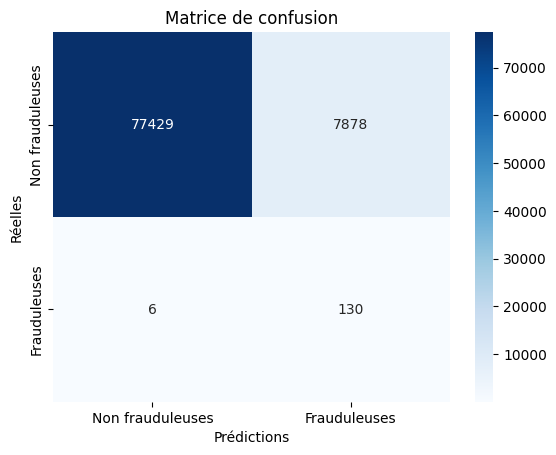

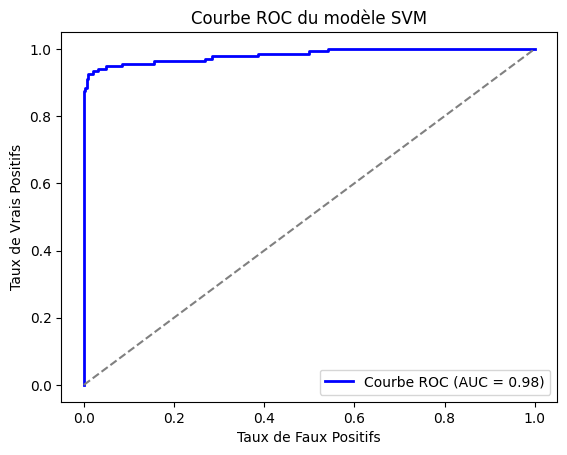

In [ ]:
# Créer le modèle SVM
linear_svc = LinearSVC(random_state=42, max_iter=10000)

# Entraîner le modèle - sur le train set rééchantillonné
linear_svc.fit(X_res, y_res)

# Prédictions sur l'ensemble de test
y_pred = linear_svc.predict(X_test)

# Évaluer les performances du modèle
print("Métriques de classification pour le SVM :")
print(classification_report(y_test, y_pred))

# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non frauduleuses', 'Frauduleuses'], yticklabels=['Non frauduleuses', 'Frauduleuses'])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réelles')
plt.show()


from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
# Calculer les probabilités pour générer la courbe ROC
# SVM ne fournit pas directement des probabilités, donc nous devons utiliser la méthode decision_function
y_score = linear_svc.decision_function(X_test)

# Binariser les labels (en cas de classification binaire, cela peut être omis)
#y_test_bin = label_binarize(y_test, classes=[0, 1])


# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC du modèle SVM')
plt.legend(loc='lower right')
plt.show()




Notre modèle, entraîné sur les classes rééquilibrées via ADASYN, détecte très bien les vrais fraudeurs (recall de 0.96), mais est un peu trop soupçonneux envers les honnêtes gens en revanche (précision, absolument médiocre, de 0.02 !!)...

Si l'objectif est que "très peu de fraudeurs passent entre les mailles du filet", notre modèle est bon. Mais c'est au prix d'un travail de vérification manuelle concernant chaque fraudeur ainsi prédit, par l'entreprise bancaire ensuite, pour trier les suspectés à tort des vrais fraudeurs.

Si l'entreprise demandeuse de ce travail de modélisation ne souhaite pas devoir effectuer ce travail manuel (ici sur près de 8000 transactions identifiées comme fraude, pour 136 fraudes réelles, tout de même), alors le modèle doit être modifié pour (beaucoup) mieux limiter les faux positifs.

Mais avant rééchantillonnage, quelles auraient été les performances de ce modèle ? Regardons cela :

Métriques de classification pour le SVM :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.87      0.60      0.71       136

    accuracy                           1.00     85443
   macro avg       0.94      0.80      0.85     85443
weighted avg       1.00      1.00      1.00     85443



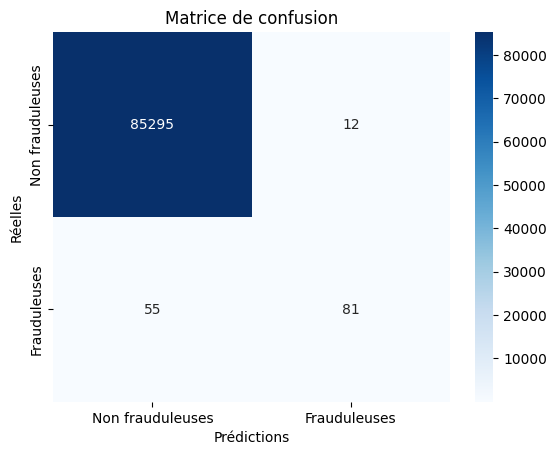

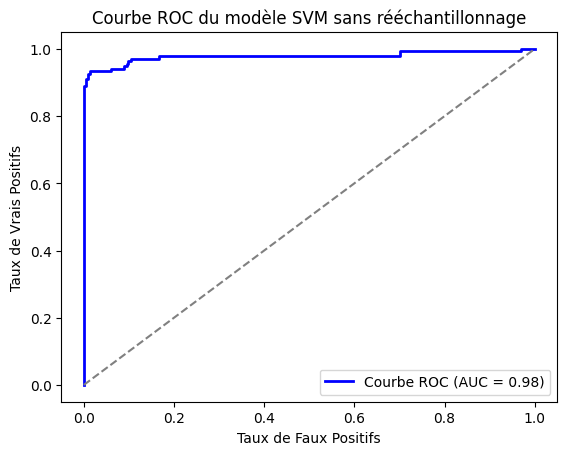

In [ ]:
# Créer le modèle SVM
linear_svc = LinearSVC(random_state=42, max_iter=10000)

# Entraîner le modèle - sur le train set non-rééchantillonné
linear_svc.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = linear_svc.predict(X_test)

# Évaluer les performances du modèle
print("Métriques de classification pour le SVM :")
print(classification_report(y_test, y_pred))

# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non frauduleuses', 'Frauduleuses'], yticklabels=['Non frauduleuses', 'Frauduleuses'])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réelles')
plt.show()


from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
# Calculer les probabilités pour générer la courbe ROC
# SVM ne fournit pas directement des probabilités, donc nous devons utiliser la méthode decision_function
y_score = linear_svc.decision_function(X_test)

# Binariser les labels (en cas de classification binaire, cela peut être omis)
#y_test_bin = label_binarize(y_test, classes=[0, 1])


# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC du modèle SVM sans rééchantillonnage')
plt.legend(loc='lower right')
plt.show()

Si la précision était meilleure, le recall quant à lui, ne dépassait pas les 60%...le modèle était donc une véritable "passoire à larges mailles" pour nos fraudeurs, dont à peine plus d'un sur deux était correctement identifié comme tel par le modèle.

Une modélisation inutilisable, donc, et par rapport à laquelle notre SVM après application d'ADASYN constitue un progrès important, même s'il comporte de trop nombreux faux positifs (et, en conséquence, un F1score proprement terrifiant, de 0.03...).



##Expérimentation avec NCR

L'algorithme  NCR (Neighbourhood cleaning rule), règle de nettoyage par voisins, vérifie les voisins de chaque exemple de la classe majoritaire et le supprime si un nombre (fixé par un paramètre) de ses voisins appartient à la classe minoritaire. Une fois cela fait, il recherche, par la méthode des plus proches voisins, si un exemple de la classe minoritaire est "mal classifié" par rapport à la classe majoritaire (c'est à dire s'il est situé "au milieu de points de la classe majoritaire") : si les voisins de cet exemple appartiennent à la classe minoritaire, ils sont conservés. S'ils appartiennent à la classe majoritaire, ils sont éliminés - et dans tous les cas, donc, on garde notre exemple membre de la classe minoritaire.

L'objectif principal de cet algorithme est donc de réduire le chevauchement entre les classes et de nettoyer les données en supprimant les exemples de la classe majoritaire qui sont proches des exemples de la classe minoritaire.

In [ ]:
"""Class performing under-sampling based on the neighbourhood cleaning rule."""

# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
#          Christos Aridas
# License: MIT

import numbers#utilisé pour manipuler et vérifier les types numériques.
import warnings#génère des avertissements pendant l'exécution du code.
from collections import Counter#Counter est une classe qui permet de compter les occurrences des éléments dans une liste
                               #(elle sera utilisée ici pour compter les classes dans l'ensemble de données).

import numpy as np
from sklearn.base import clone#permet de créer une copie d'un modèle ou d'un estimateur.
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors#classes utilisées pour les algorithmes de voisinage k-NN.
from sklearn.utils import _safe_indexing#permet d'extraire des sous-ensembles de données de manière sécurisée.
from sklearn.utils._param_validation import HasMethods, Hidden, Interval, StrOptions#outils de validation de paramètres utilisés pour valider les arguments passés à la classe.

from ...utils import Substitution#Importe le décorateur Substitution depuis un module interne
                                 #(ce décorateur sera utilisé pour gérer les substitutions dans les chaînes de documentation~).
from ...utils._docstring import _n_jobs_docstring#importe un document de chaîne de caractères lié à la gestion du paramètre n_jobs pour spécifier le nombre de jobs parallèles.
from ..base import BaseCleaningSampler#BaseCleaningSampler est la classe de base pour les techniques de nettoyage des données.
from ._edited_nearest_neighbours import EditedNearestNeighbours#la classe EditedNearestNeighbours est utilisée pour le nettoyage initial des échantillons en appliquant l'algorithme ENN.

SEL_KIND = ("all", "mode")#Déclare un tuple contenant les valeurs possibles pour la stratégie de sélection des voisins dans l'algorithme ENN ("all" ou "mode").
# Cette variable est dépréciée et ne sera donc plus utilisée dans le script.


@Substitution(#je ne comprends pas ce que fait ce décorateur
    sampling_strategy=BaseCleaningSampler._sampling_strategy_docstring,
    n_jobs=_n_jobs_docstring,
)
class NeighbourhoodCleaningRule(BaseCleaningSampler):#Définit la classe NeighbourhoodCleaningRule, qui hérite de la classe BaseCleaningSampler.
    """Undersample based on the neighbourhood cleaning rule.

    This class uses ENN and a k-NN to remove noisy samples from the datasets.

    Read more in the :ref:`User Guide <condensed_nearest_neighbors>`.

    Parameters
    ----------
    {sampling_strategy}

    edited_nearest_neighbours : estimator object, default=None
        The :class:`~imblearn.under_sampling.EditedNearestNeighbours` (ENN)
        object to clean the dataset. If `None`, a default ENN is created with
        `kind_sel="mode"` and `n_neighbors=n_neighbors`.

    n_neighbors : int or estimator object, default=3
        If ``int``, size of the neighbourhood to consider to compute the
        K-nearest neighbors. If object, an estimator that inherits from
        :class:`~sklearn.neighbors.base.KNeighborsMixin` that will be used to
        find the nearest-neighbors. By default, it will be a 3-NN.

    kind_sel : {{"all", "mode"}}, default='all'
        Strategy to use in order to exclude samples in the ENN sampling.

        - If ``'all'``, all neighbours will have to agree with the samples of
          interest to not be excluded.
        - If ``'mode'``, the majority vote of the neighbours will be used in
          order to exclude a sample.

        The strategy `"all"` will be less conservative than `'mode'`. Thus,
        more samples will be removed when `kind_sel="all"` generally.

        .. deprecated:: 0.12
           `kind_sel` is deprecated in 0.12 and will be removed in 0.14.
           Currently the parameter has no effect and corresponds always to the
           `"all"` strategy.

    threshold_cleaning : float, default=0.5
        Threshold used to whether consider a class or not during the cleaning
        after applying ENN. A class will be considered during cleaning when:

        Ci > C x T ,

        where Ci and C is the number of samples in the class and the data set,
        respectively and theta is the threshold.

    {n_jobs}

    Attributes
    ----------
    sampling_strategy_ : dict
        Dictionary containing the information to sample the dataset. The keys
        corresponds to the class labels from which to sample and the values
        are the number of samples to sample.

    edited_nearest_neighbours_ : estimator object
        The edited nearest neighbour object used to make the first resampling.

    nn_ : estimator object
        Validated K-nearest Neighbours object created from `n_neighbors` parameter.

    classes_to_clean_ : list
        The classes considered with under-sampling by `nn_` in the second cleaning
        phase.

    sample_indices_ : ndarray of shape (n_new_samples,)
        Indices of the samples selected.

        .. versionadded:: 0.4

    n_features_in_ : int
        Number of features in the input dataset.

        .. versionadded:: 0.9

    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during `fit`. Defined only when `X` has feature
        names that are all strings.

        .. versionadded:: 0.10

    See Also
    --------
    EditedNearestNeighbours : Undersample by editing noisy samples.

    Notes
    -----
    See the original paper: [1]_.

    Supports multi-class resampling. A one-vs.-rest scheme is used when
    sampling a class as proposed in [1]_.

    References
    ----------
    .. [1] J. Laurikkala, "Improving identification of difficult small classes
       by balancing class distribution," Springer Berlin Heidelberg, 2001.

    Examples
    --------
    >>> from collections import Counter
    >>> from sklearn.datasets import make_classification
    >>> from imblearn.under_sampling import NeighbourhoodCleaningRule
    >>> X, y = make_classification(n_classes=2, class_sep=2,
    ... weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
    ... n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
    >>> print('Original dataset shape %s' % Counter(y))
    Original dataset shape Counter({{1: 900, 0: 100}})
    >>> ncr = NeighbourhoodCleaningRule()
    >>> X_res, y_res = ncr.fit_resample(X, y)
    >>> print('Resampled dataset shape %s' % Counter(y_res))
    Resampled dataset shape Counter({{1: 888, 0: 100}})
    """
    #Le dictionnaire parameter_constraints définit les contraintes de validation des paramètres pour cette classe.
    #Par exemple, n_neighbors doit être un entier positif, threshold_cleaning doit être un nombre réel, etc.
    _parameter_constraints: dict ={
        **BaseCleaningSampler._parameter_constraints,
        "edited_nearest_neighbours": [
            HasMethods(["fit_resample"]),
            None,
        ],
        "n_neighbors": [
            Interval(numbers.Integral, 1, None, closed="left"),
            HasMethods(["kneighbors", "kneighbors_graph"]),
        ],
        "kind_sel": [StrOptions({"all", "mode"}), Hidden(StrOptions({"deprecated"}))],
        "threshold_cleaning": [Interval(numbers.Real, 0, None, closed="neither")],
        "n_jobs": [numbers.Integral, None],
    }

    def __init__(
    #Constructeur de la classe. Il initialise les paramètres par défaut, dont :

    #sampling_strategy="auto" : La stratégie de sous-échantillonnage.
    #edited_nearest_neighbours=None : L'estimateur ENN à utiliser (si None, l'ENN par défaut est créé).
    #n_neighbors=3 : Le nombre de voisins pour l'algorithme k-NN.
    #kind_sel="deprecated" : La stratégie de sélection, maintenant dépréciée.
    #threshold_cleaning=0.5 : Le seuil de nettoyage des classes.
    #n_jobs=None : Le nombre de jobs parallèles.
        self,
        *,
        sampling_strategy="auto",
        edited_nearest_neighbours=None,
        n_neighbors=3,
        kind_sel="deprecated",
        threshold_cleaning=0.5,
        n_jobs=None,
    ):
        super().__init__(sampling_strategy=sampling_strategy)#initialise la classe parente et les attributs de la classe NeighbourhoodCleaningRule.
        self.edited_nearest_neighbours = edited_nearest_neighbours
        self.n_neighbors = n_neighbors
        self.kind_sel = kind_sel
        self.threshold_cleaning = threshold_cleaning
        self.n_jobs = n_jobs

    def _validate_estimator(self):#Méthode pour valider et créer les objets nécessaires au nettoyage.
        """Create the objects required by NCR."""
        if isinstance(self.n_neighbors, numbers.Integral):
            self.nn_ = KNeighborsClassifier(
                n_neighbors=self.n_neighbors, n_jobs=self.n_jobs
            )#Si n_neighbors est un entier, un classificateur KNeighborsClassifier est créé avec le nombre de voisins spécifié et le nombre de jobs parallèles.
        elif isinstance(self.n_neighbors, NearestNeighbors):
            # backward compatibility when passing a NearestNeighbors object
            self.nn_ = KNeighborsClassifier(
                n_neighbors=self.n_neighbors.n_neighbors - 1, n_jobs=self.n_jobs
            )#Si n_neighbors est un objet NearestNeighbors, un KNeighborsClassifier est créé avec n_neighbors ajusté.
        else:
            self.nn_ = clone(self.n_neighbors)#Si n_neighbors est déjà un estimateur, il est cloné pour être utilisé dans la validation.

        if self.edited_nearest_neighbours is None:#Si edited_nearest_neighbours est None, un objet EditedNearestNeighbours par défaut est créé. Sinon, l'objet passé est cloné.
            self.edited_nearest_neighbours_ = EditedNearestNeighbours(
                sampling_strategy=self.sampling_strategy,
                n_neighbors=self.n_neighbors,
                kind_sel="mode",
                n_jobs=self.n_jobs,
            )
        else:
            self.edited_nearest_neighbours_ = clone(self.edited_nearest_neighbours)

    def _fit_resample(self, X, y):#Méthode qui effectue le sous-échantillonnage des données X et des étiquettes y.
        if self.kind_sel != "deprecated":
            warnings.warn(
                (
                    "`kind_sel` is deprecated in 0.12 and will be removed in 0.14. "
                    "It already has not effect and corresponds to the `'all'` option."
                ),
                FutureWarning,
            )
        self._validate_estimator()#Valide l'estimateur (création des objets nécessaires).
        self.edited_nearest_neighbours_.fit_resample(X, y)#Applique l'ENN pour effectuer un premier nettoyage.
        index_not_a1 = self.edited_nearest_neighbours_.sample_indices_#Récupère les indices des échantillons qui ne sont pas conservés après l'ENN.
        #Création d'un tableau index_a1 pour marquer les échantillons conservés après l'ENN :
        index_a1 = np.ones(y.shape, dtype=bool)
        index_a1[index_not_a1] = False
        index_a1 = np.flatnonzero(index_a1)

        # clean the neighborhood - Compter les occurrences des classes et identifier la classe minoritaire :
        target_stats = Counter(y)
        class_minority = min(target_stats, key=target_stats.get)
        #Identifier les classes à nettoyer en fonction de la taille relative à la classe minoritaire et du seuil threshold_cleaning :
        self.classes_to_clean_ = [
            c
            for c, n_samples in target_stats.items()
            if (
                c in self.sampling_strategy_.keys()
                and (n_samples > target_stats[class_minority] * self.threshold_cleaning)
            )
        ]
        self.nn_.fit(X, y)#Entraîne le classificateur k-NN sur les données.

        #Extraction des indices des échantillons de la classe minoritaire :
        class_minority_indices = np.flatnonzero(y == class_minority)
        X_minority = _safe_indexing(X, class_minority_indices)
        y_minority = _safe_indexing(y, class_minority_indices)

        y_pred_minority = self.nn_.predict(X_minority)#Prédit les étiquettes des échantillons minoritaires à l'aide du classificateur k-NN.
        #Trouver les voisins de chaque échantillon minoritaire :
        neighbors_to_minority_indices = self.nn_.kneighbors(
            X_minority, n_neighbors=self.nn_.n_neighbors + 1, return_distance=False
        )[:, 1:]

        mask_misclassified_minority = y_pred_minority != y_minority#Marque les échantillons minoritaires mal classifiés et récupère les indices de leurs voisins.
        index_a2 = np.ravel(neighbors_to_minority_indices[mask_misclassified_minority])
        #Filtre les voisins mal classifiés en fonction des classes à nettoyer :
        index_a2 = np.array(
            [
                index
                for index in np.unique(index_a2)
                if y[index] in self.classes_to_clean_
            ]
        )

        union_a1_a2 = np.union1d(index_a1, index_a2).astype(int)#Fait l'union des indices des échantillons conservés et des échantillons mal classifiés pour les nettoyer.
        selected_samples = np.ones(y.shape, dtype=bool)#création d'un tableau de booléens de la même forme que y (la cible des étiquettes de classe) où toutes les valeurs sont initialisées à True.
        selected_samples[union_a1_a2] = False#Cette ligne met à jour le tableau selected_samples en attribuant la valeur False aux indices présents dans union_a1_a2.
                                             #Cela signifie que les exemples correspondant à ces indices sont exclus du jeu de données après le nettoyage.
        self.sample_indices_ = np.flatnonzero(selected_samples)#renvoie les indices pour lesquels la valeur de selected_samples est True, c'est-à-dire les indices
                                                               #des exemples qui n'ont pas été exclus. Ces indices sont stockés dans l'attribut self.sample_indices_.

        #sélection sécurisée des échantillons de X et des étiquettes y en fonction des indices présents dans self.sample_indices_.
        #Cela permet de récupérer uniquement les échantillons qui ont été sélectionnés
        return (
            _safe_indexing(X, self.sample_indices_),
            _safe_indexing(y, self.sample_indices_),
        )

    def _more_tags(self):#méthode qui fait partie du système de métadonnées de scikit-learn et permet d'ajouter des informations supplémentaires sur le comportement du modèle.
        return {"sample_indices": True}

    def __sklearn_tags__(self):#Méthode qui renvoie les tags complets des objets, qui seront utilisés par scikit-learn ou d'autres outils pour mieux comprendre leur fonctionnement.
        tags = super().__sklearn_tags__()
        tags.sampler_tags.sample_indices = True
        return tags

La méthode NCR, tout comme ADASYN, fait en fait déjà partie du package imblearn.under_sampling.

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NeighbourhoodCleaningRule


ncr = NeighbourhoodCleaningRule()

X_res, y_res = ncr.fit_resample(X_train, y_train)

print('Répartition des classes après rééchantillonnage :  %s' % Counter(y_res))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The NeighbourhoodCleaningRule or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `skl

Répartition des classes après rééchantillonnage :  Counter({0: 198790, 1: 356})


On voit que le paramétrage par défaut de NCR conduit à des suppressions très insuffisantes d'exemples de la classe majoritaire (on est passés de 199008 à 198790). Notre ensemble est tellement déséquilibré, qu'il est compliqué de trouver des voisins de points de la classe minoritaire !

Métriques de classification pour le SVM :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.86      0.71      0.78       136

    accuracy                           1.00     85443
   macro avg       0.93      0.86      0.89     85443
weighted avg       1.00      1.00      1.00     85443



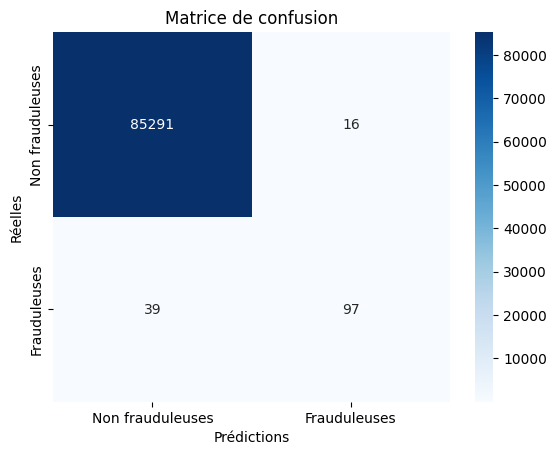

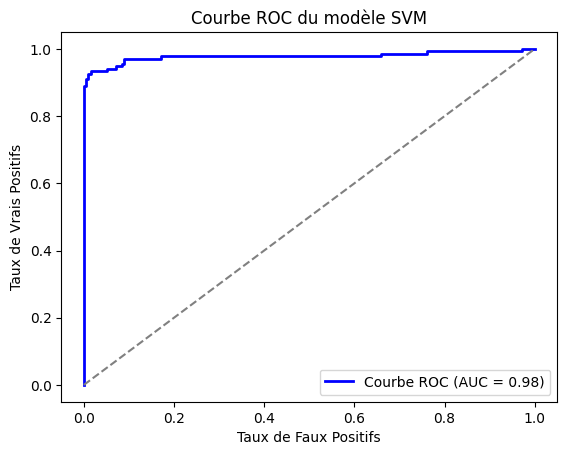

In [ ]:
# Créer le modèle SVM
linear_svc = LinearSVC(random_state=42, max_iter=10000)

# Entraîner le modèle - sur le train set rééchantillonné
linear_svc.fit(X_res, y_res)

# Prédictions sur l'ensemble de test
y_pred = linear_svc.predict(X_test)

# Évaluer les performances du modèle
print("Métriques de classification pour le SVM :")
print(classification_report(y_test, y_pred))

# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non frauduleuses', 'Frauduleuses'], yticklabels=['Non frauduleuses', 'Frauduleuses'])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réelles')
plt.show()


from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
# Calculer les probabilités pour générer la courbe ROC
# SVM ne fournit pas directement des probabilités, donc nous devons utiliser la méthode decision_function
y_score = linear_svc.decision_function(X_test)

# Binariser les labels (en cas de classification binaire, cela peut être omis)
#y_test_bin = label_binarize(y_test, classes=[0, 1])


# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC du modèle SVM')
plt.legend(loc='lower right')
plt.show()

Par rapport au modèle avant rééchantillonnage, les performances diffèrent à peine : seul le recall est légèrement "amélioré" : c'est médiocre.

Il est précisé dans l'article joint à la méthode NCR, que cette méthode s'attache plus à "nettoyer les données" pour améliorer la séparation entre les classes, qu'à en réduire la taille. Une des justifications à cela était que "la qualité des résultats de classification ne dépend pas nécessairement de la taille de la classe. Par conséquent, nous devrions considérer, en plus de la distribution des classes, d'autres caractéristiques des données, telles que le bruit, qui peuvent entraver la classification.".

Force est de constater que dans notre ensemble de données, l'élimination du bruit ne conduit pas à améliorer de façon significative la détection des fraudeurs.

Essayons de modifier les paramètres par défaut de l'algorithme pour voir si cela peut évoluer.

In [ ]:
ncr = NeighbourhoodCleaningRule(n_neighbors=100)

X_res, y_res = ncr.fit_resample(X_train, y_train)

print('Répartition des classes après rééchantillonnage :  %s' % Counter(y_res))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The NeighbourhoodCleaningRule or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `skl

Répartition des classes après rééchantillonnage :  Counter({0: 192457, 1: 356})


En augmentant de manière importante la valeur par défaut du paramètre "n_neighbors" de l'algorithme, on arrive à supprimer, péniblement, 6000 exemples de la classe majoritaire.

Ce n'est toujours pas suffisant pour rééquilibrer nos classes en effectifs. Qu'en est-il des performances du modèle : le côté "nettoyeur" de l'algorithme les a-t-il améliorées ?

Métriques de classification pour le SVM :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.78      0.83      0.80       136

    accuracy                           1.00     85443
   macro avg       0.89      0.92      0.90     85443
weighted avg       1.00      1.00      1.00     85443



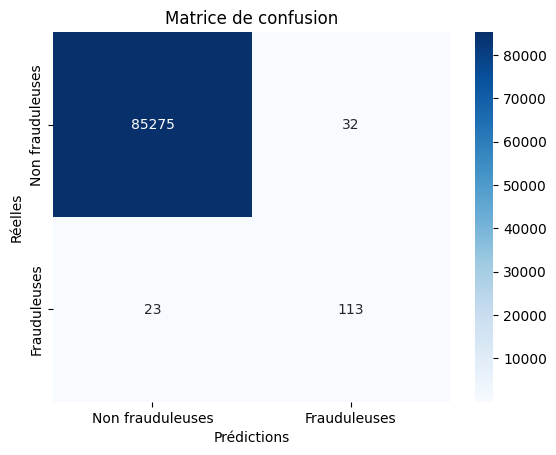

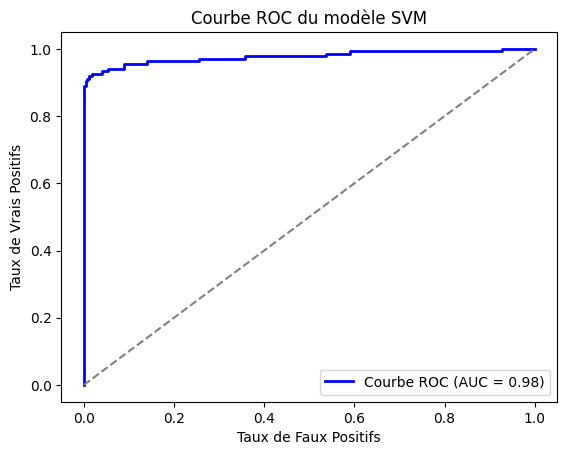

In [ ]:
# Créer le modèle SVM
linear_svc = LinearSVC(random_state=42, max_iter=10000)

# Entraîner le modèle - sur le train set rééchantillonné
linear_svc.fit(X_res, y_res)

# Prédictions sur l'ensemble de test
y_pred = linear_svc.predict(X_test)

# Évaluer les performances du modèle
print("Métriques de classification pour le SVM :")
print(classification_report(y_test, y_pred))

# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non frauduleuses', 'Frauduleuses'], yticklabels=['Non frauduleuses', 'Frauduleuses'])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réelles')
plt.show()


from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
# Calculer les probabilités pour générer la courbe ROC
# SVM ne fournit pas directement des probabilités, donc nous devons utiliser la méthode decision_function
y_score = linear_svc.decision_function(X_test)

# Binariser les labels (en cas de classification binaire, cela peut être omis)
#y_test_bin = label_binarize(y_test, classes=[0, 1])


# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC du modèle SVM')
plt.legend(loc='lower right')
plt.show()

Le recall commence à s'améliorer de manière plus marquée, et plus de fraudeurs sont identifiés comme tels.

Si l'objectif de l'entreprise est d'identifier la majorité des fraudeurs, quitte à en laisser quelques uns passer entre les mailles, mais en s'évitant la vérification manuelle de nombreux dossiers de suspects de fraude identifiés à tort comme tels par le modèle (cas avec l'algorithme ADASYN), il peut constituer un bon compromis.

Dernier essai : en augmentant de manière outrancière la valeur par défaut du paramètre "n_neighbors" de l'algorithme (on le passe à 1000), on arrive à supprimer 81634 exemples de la classe majoritaire - qui reste néanmoins toujours très majoritaire.

Que devient le modèle de SVM avec ce nouveau rééchantillonnage ?

In [ ]:
ncr = NeighbourhoodCleaningRule(n_neighbors=1000)

X_res, y_res = ncr.fit_resample(X_train, y_train)

print('Répartition des classes après rééchantillonnage :  %s' % Counter(y_res))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The NeighbourhoodCleaningRule or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `skl

Répartition des classes après rééchantillonnage :  Counter({0: 117156, 1: 356})


Métriques de classification pour le SVM :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.33      0.89      0.48       136

    accuracy                           1.00     85443
   macro avg       0.67      0.94      0.74     85443
weighted avg       1.00      1.00      1.00     85443



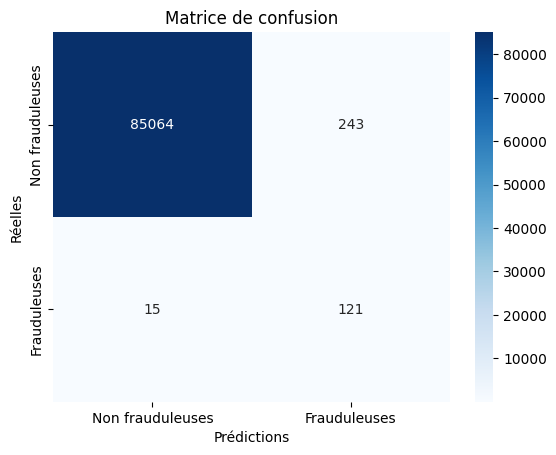

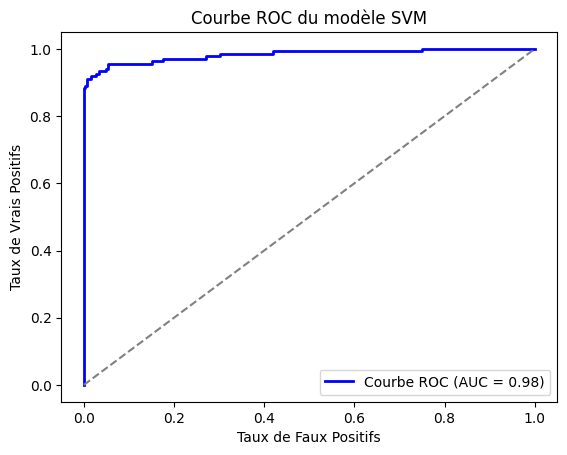

In [ ]:
# Créer le modèle SVM
linear_svc = LinearSVC(random_state=42, max_iter=10000)

# Entraîner le modèle - sur le train set rééchantillonné
linear_svc.fit(X_res, y_res)

# Prédictions sur l'ensemble de test
y_pred = linear_svc.predict(X_test)

# Évaluer les performances du modèle
print("Métriques de classification pour le SVM :")
print(classification_report(y_test, y_pred))

# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non frauduleuses', 'Frauduleuses'], yticklabels=['Non frauduleuses', 'Frauduleuses'])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réelles')
plt.show()



from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
# Calculer les probabilités pour générer la courbe ROC
# SVM ne fournit pas directement des probabilités, donc nous devons utiliser la méthode decision_function
y_score = linear_svc.decision_function(X_test)

# Binariser les labels (en cas de classification binaire, cela peut être omis)
#y_test_bin = label_binarize(y_test, classes=[0, 1])


# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC du modèle SVM')
plt.legend(loc='lower right')
plt.show()

Le recall devient très bon, mais la précision se dégrade : les dossiers de suspects de fraude croissent en nombre mais sans ajouts de vrais fraudeurs à proportion.

Le score F1 se dégrade fortement, du fait de cette perte de précision : numériquement, pour 8 vraies transactions frauduleuses saisies dans les mailles du filet en plus, nous héritons, en contrepartie de plusieurs centaines de transactions identifiées à tort comme frauduleuses.

#En conclusion, parmi les configurations testées, le meilleur (ou moins mauvais) modèle me semble être celui avec le NCR reparamétré avec n_neighbor=100.

J'ai choisi un peu "au hasard" mes deux algorithmes de rééquilibrage - je voulais en tester un dans la catégorie "over-sampling", et un dans la catégorie "under-sampling" ; j'ai prioritairement retenu des méthodes pour lesquelles un "paper" existait à côté du code. Puis j'ai choisi mon jeu de données.

Le bilan que je fais est qu'il faut bien sûr d'abord regarder les caractéristiques du jeu de données : qu'est-ce qui sera le plus adapté à des données où la classe minoritaire comporte moins de 500 exemples, et représente 0.001% du total environ... ?

L'under-sampling ne semble pas la bonne réponse. Pourtant, re-paramétré, il s'avère le moins mauvais choix parmi les deux méthodes explorées.

Je pense cependant que pour des classes minoritaires aussi infimes en proportion des données, si c'était à refaire, dans la liste des algorithmes proposés en test pour le projet, j'explorerais plutôt parmi les algorithmes "mixtes" au lieu d'algorithmes d'under-sampling (en plus de ceux d'over-sampling simple). En autre voie extérieure à cette liste, après les présents essais et au vu de leurs résultats, je tenterais volontiers une clusterisation de la classe majoritaire (une des options présentées en cours).